In [2]:
!pip install numpy
!pip install matplotlib
!pip install seaborn

In [3]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
DATASET_TYPE = "linear" # linear, polinomial, sin

In [5]:
def generate_examples(dataset_type = "linear", N = 9, noise = 0.2, dist_noise = 0.2):
    if dataset_type == "linear":
        X = np.linspace(0, 10, N)
        t = X * 0.25 + 1.75 + np.random.randn(N) * noise
        return X, t
    
    elif dataset_type == "polinomial":
        X = np.linspace(-1.5, 5.5, N)
        X += np.random.randn(N) * dist_noise
        t = .25*X * X - X + 1 + np.random.randn(N) * noise
        return X, t
    
    elif dataset_type == "sin":
        X = np.linspace(0, 1.75 * np.pi, N)
        X += np.random.randn(N) * dist_noise
        t = np.sin(X) + np.random.randn(N) * noise
        return X, t
    
    else:
        raise ValueError("Unknown dataset type: " + dataset_type)

In [6]:
class LinearRegression(object):
    """
    Modelul de Regresie Liniara
    y = X @ w 
        - valoarea prezisă de model
    t ~ N(t|X @ w, var) 
        - valorile de antrenare (target) sunt fac parte dintr-o distributie normala in jurul mean-ului X@w, 
          la care se adauga zgomot dat de varianta `var`
    """

    def fit(self, X, t):
        """
        Antrenarea modelului in sensul celor mai mici patrate (least squares fitting)
        Parameterii
        ----------
        X : (N, D) np.ndarray
            variabilele de intrare
        t : (N,) np.ndarray
            variabilele tinta (target / ground truth)
        """
        # TODO codul vostru aici: calculati vectorul de ponderi w
        self.w = np.linalg.pinv(X) @ t
        # end 
        
        self.var = np.mean(np.square(X @ self.w - t))

    def predict(self, X, return_std=False):
        """
        Intoarce valoari prezise de model pentru sample-uri X
        Parametrii
        ----------
        X : (N, D) np.ndarray
            sample-uri de valori D-dimensionale pentru care se doreste predictia valorii conform modelului
        return_std : bool, optional
            intoarce deviatia standard a fiecarei valori prezice, daca e setat pe True
        
        Intoarce
        -------
        y : (N,) np.ndarray
            vector de valori prezise
        y_std : (N,) np.ndarray
            deviatia standard a fiecarei valori prezise
        """
        # TODO codul vostru aici: calculati valoarea prezisa de modelul vostru
        y = X @ self.w  
        # end codul vostru aici
        
        if return_std:
            # TODO codul vostru aici: intoarceti un vector de aceeasi dimensiune cu y, care 
            # are pe fiecare valoare egala cu deviatia standard modelului antrenat (i.e. sqrt(var))
            y_std = np.sqrt(self.var)
            return y, y_std
        return y

In [7]:
def extract_polynomial_features(X, M):
    # TODO codul vostru aici: intoarceti valorile phi_n astfel incat pentru fiecare 
    # intrare x phi_n = [1, x, x^2, ..., x^M]
    return np.array([x ** np.arange(M + 1) for x in X])
    # end

In [8]:
N_train = 10
N_test = 10
noise = 0.22

X_train, t_train = generate_examples(dataset_type="linear", N=N_train, noise=noise)
X_test, t_test = generate_examples(dataset_type="linear", N=N_test, noise=noise)
X_real, t_real = generate_examples(dataset_type="linear", N=N_test, noise=0.)

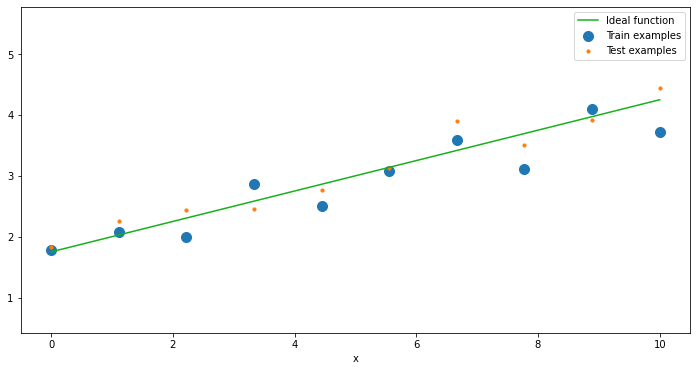

In [10]:
plt.figure(figsize=(12,6)); plt.axis('equal')
plt.plot(X_real, t_real, sns.xkcd_rgb["green"], label="Ideal function")
plt.scatter(X_train, t_train, s=100, label="Train examples")
plt.scatter(X_test, t_test, s=10, label="Test examples")
plt.xlabel("x")
plt.legend(bbox_to_anchor=(1, 1), loc='upper right', ncol=1)
plt.show()

In [11]:
# TODO codul vostru aici:
# creati un model liniar
model = LinearRegression()

# Folositi functia extract_polynomial_features pentru a introduce termenul de bias in matricile X_train si X_test
X_train_feat = extract_polynomial_features(X_train, 1)
X_test_feat = extract_polynomial_features(X_test, 1)

# antrenati modelul vostru
model.fit(X_train_feat, t_train)

# obtineti predictia pe setul de antrenare si pe setul de test
y_train = model.predict(X_train_feat)
y_test, y_test_std = model.predict(X_test_feat, return_std=True)

In [12]:
def mean_squared_error(y, t):
    return np.mean((y - t) * (y- t))

In [13]:
print("Train error:", mean_squared_error(y_train, t_train))
print("Test  error:", mean_squared_error(y_test, t_test))

Train error: 0.07265290713853303
Test  error: 0.08051011356480796


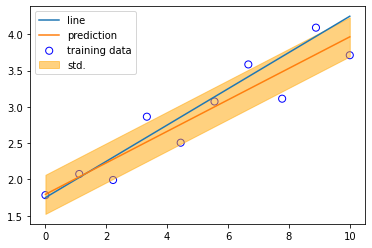

In [14]:
plt.scatter(X_train, t_train, facecolor="none", edgecolor="b", s=50, label="training data")
plt.plot(X_real, t_real, label="line")
plt.plot(X_test, y_test, label="prediction")
plt.fill_between(
    X_test, y_test - y_test_std, y_test + y_test_std,
    color="orange", alpha=0.5, label="std.")
plt.legend()
plt.show()

In [15]:
class RidgeRegression(LinearRegression):
    """
    Modelul de regresie liniara, folosind regularizare L2
    w* = argmin |t - X @ w| + alpha * |w|_2^2
    """

    def __init__(self, alpha:float=1.):
        super(RidgeRegression, self).__init__()
        self.alpha = alpha

        
    def fit(self, X:np.ndarray, t:np.ndarray):
        """
        Antrenarea modelului in sensul celor mai mici patrate (least squares fitting), tinand cont si de regularizare
        Parameterii
        ----------
         X : (N, D) np.ndarray
            variabilele de intrare
        t : (N,) np.ndarray
            variabilele tinta (target / ground truth)
        """
        # TODO codul vostru aici: calculati vectorul de ponderi w, conform formulei de la punctul 5 
        X_t = np.transpose(X)
        self.w = np.linalg.inv(X_t @ X + self.alpha * np.identity(X.shape[1])) @ X_t @ t
        # end
        
        self.var = np.mean(np.square(X @ self.w - t))

In [16]:
N_train = 20 #@param {type: "slider", default: 10, min: 10, max: 100}
N_test = 20
noise = 0.22

X_train, t_train = generate_examples(dataset_type="sin", N=N_train, noise=noise)
X_test, t_test = generate_examples(dataset_type="sin", N=N_test, noise=noise)
X_real, t_real = generate_examples(dataset_type="sin", N=100, noise=.0, dist_noise=.0)

In [17]:
M = 3 #@param {type: "slider", default: 8, min: 1, max: 15}
X_train_feat = extract_polynomial_features(X_train, M)
X_test_feat = extract_polynomial_features(X_test, M)

model = LinearRegression()
model.fit(X_train_feat, t_train)

y_train = model.predict(X_train_feat, return_std=False) 
y_test, y_test_std = model.predict(X_test_feat, return_std=True)

Train error: 0.038926530604260504
Test  error: 0.05811978043560219


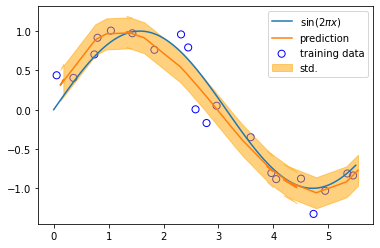

In [18]:
print("Train error:", mean_squared_error(y_train, t_train))
print("Test  error:", mean_squared_error(y_test, t_test))

# Plot
plt.scatter(X_train, t_train, facecolor="none", edgecolor="b", s=50, label="training data")
plt.plot(X_real, t_real, label="$\sin(2\pi x)$")
plt.plot(X_test, y_test, label="prediction")
plt.fill_between(
    X_test, y_test - y_test_std, y_test + y_test_std,
    color="orange", alpha=0.5, label="std.")
plt.legend()
plt.show()

In [19]:
model = RidgeRegression(alpha=1.75)
model.fit(X_train_feat, t_train)

y_train = model.predict(X_train_feat, return_std=False) 
y_test, y_test_std = model.predict(X_test_feat, return_std=True)

Train error: 0.08128987214932451
Test  error: 0.07657244230772052


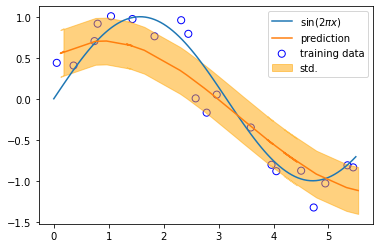

In [20]:
print("Train error:", mean_squared_error(y_train, t_train))
print("Test  error:", mean_squared_error(y_test, t_test))

# Plot
plt.scatter(X_train, t_train, facecolor="none", edgecolor="b", s=50, label="training data")
plt.plot(X_real, t_real, label="$\sin(2\pi x)$")
plt.plot(X_test, y_test, label="prediction")
plt.fill_between(
    X_test, y_test - y_test_std, y_test + y_test_std,
    color="orange", alpha=0.5, label="std.")
plt.legend()
plt.show()

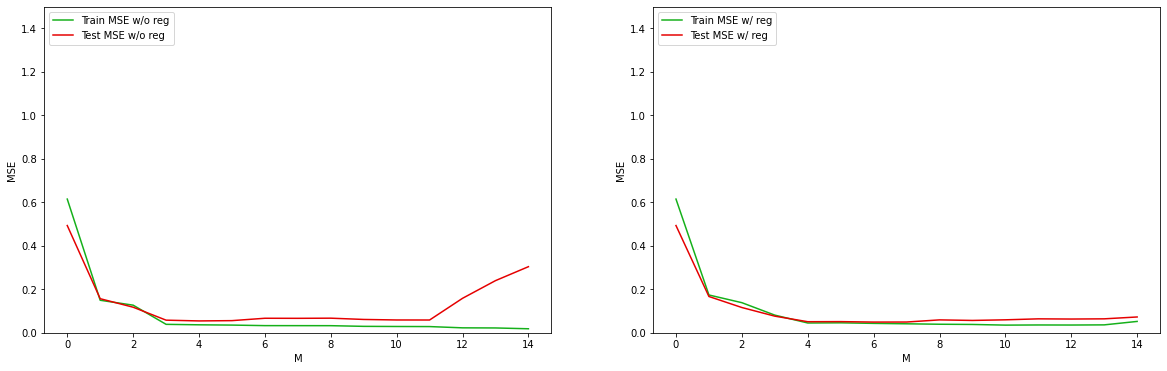

In [21]:
train_lin_mse = []
test_lin_mse = []

train_ridge_mse = []
test_ridge_mse = []

for M in range(15):
    X_train_feat = extract_polynomial_features(X_train, M)
    X_test_feat = extract_polynomial_features(X_test, M)
    
    model_linear = LinearRegression()
    model_ridge = RidgeRegression(alpha=1.75)
    
    model_linear.fit(X_train_feat, t_train)
    model_ridge.fit(X_train_feat, t_train)
    
    y_train_lin = model_linear.predict(X_train_feat)
    y_test_lin = model_linear.predict(X_test_feat)
    
    y_train_ridge = model_ridge.predict(X_train_feat)
    y_test_ridge = model_ridge.predict(X_test_feat)
    
    train_lin_mse.append(mean_squared_error(y_train_lin, t_train))
    test_lin_mse.append(mean_squared_error(y_test_lin, t_test))
    
    train_ridge_mse.append(mean_squared_error(y_train_ridge, t_train))
    test_ridge_mse.append(mean_squared_error(y_test_ridge, t_test))

plt.figure(figsize=(20,6))
# plot training/test curves depending on model size for LinearRegression
plt.subplot(1, 2, 1)
plt.plot(range(M+1), train_lin_mse, sns.xkcd_rgb["green"], label="Train MSE w/o reg")
plt.plot(range(M+1), test_lin_mse, sns.xkcd_rgb["red"], label="Test MSE w/o reg")
plt.xlabel("M")
plt.ylabel("MSE")
plt.legend(bbox_to_anchor=(0, 1), loc='upper left', ncol=1)
plt.ylim(0, 1.5)

# plot training/test curves depending on model size for RidgeRegression
plt.subplot(1, 2, 2)
plt.plot(range(M+1), train_ridge_mse, sns.xkcd_rgb["green"], label="Train MSE w/ reg")
plt.plot(range(M+1), test_ridge_mse, sns.xkcd_rgb["red"], label="Test MSE w/ reg")
plt.xlabel("M")
plt.ylabel("MSE")
plt.legend(bbox_to_anchor=(0, 1), loc='upper left', ncol=1)
plt.ylim(0, 1.5)

plt.show()